In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.transforms import blended_transform_factory
from mpl_toolkits.axes_grid1 import ImageGrid
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar

import numpy as np

import patato as pat
from PIL import Image

import scienceplots

plt.style.use(["vibrant"])

from paiskintonetools import setup_matplotlib
from paiskintonetools.stats import p_formatter

setup_matplotlib(dpi=200)
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [2]:
scan = "Data/SKIN33/Scan_3.hdf5"
pat_vitiligo = pat.PAData.from_hdf5(scan)
pat_vitiligo.set_default_recon(("Model Based", "0"))
xs = pat_vitiligo.get_scan_reconstructions().da.coords["x"].values
pa_weighting = np.exp(xs * 100)

In [3]:
forearm_wood = Image.open("skin36_uv.jpg")
forearm_light = Image.open("skin36_light.jpg")

In [4]:
%config InlineBackend.print_figure_kwargs = {'bbox_inches':None}

In [5]:
df = pd.read_parquet("../01_Prepare Data/pa_values_extracted_all_meta.parquet")
df = df.query("`Fitzpatrick Type` == 'Vitiligo'")
df = df.query("`ROI Name` == 'skin'")
df["pa"] = df["spectrum_mean"].apply(lambda x: x[0])

df = (
    df.groupby(["SkinID", "Region", "Pigment", "Side"])
    .mean(numeric_only=True)
    .reset_index()
)

In [6]:
def get_position(x):
    if x in ["Radial Artery", "Brachial Artery", "Ulnar Artery"]:
        return "Forearm"
    else:
        return x


colors = {x: f"C{i}" for i, x in enumerate(sorted(pd.unique(df["SkinID"])))}
handles = [
    Line2D([], [], color=c, marker="o", markersize=5, label=y)
    for y, c in colors.items()
]
labels = list([x[-2:] for x in colors.keys()])

df["Colour"] = df["SkinID"].apply(lambda x: colors[x])

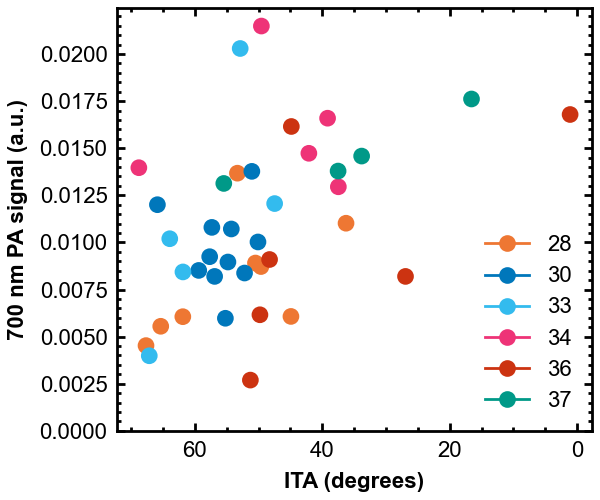

In [8]:
fig, ax = plt.subplots(figsize=(3, 2.5))
ax.scatter(df["ITA"], df["pa"], c=df["Colour"])
ax.invert_xaxis()
ax.legend(handles, labels, loc="lower right")
ax.set_xlabel("ITA (degrees)")
ax.set_ylabel("700 nm PA signal (a.u.)")
ax.set_ylim([0, None])
plt.show()

NameError: name 'df_pig_included' is not defined

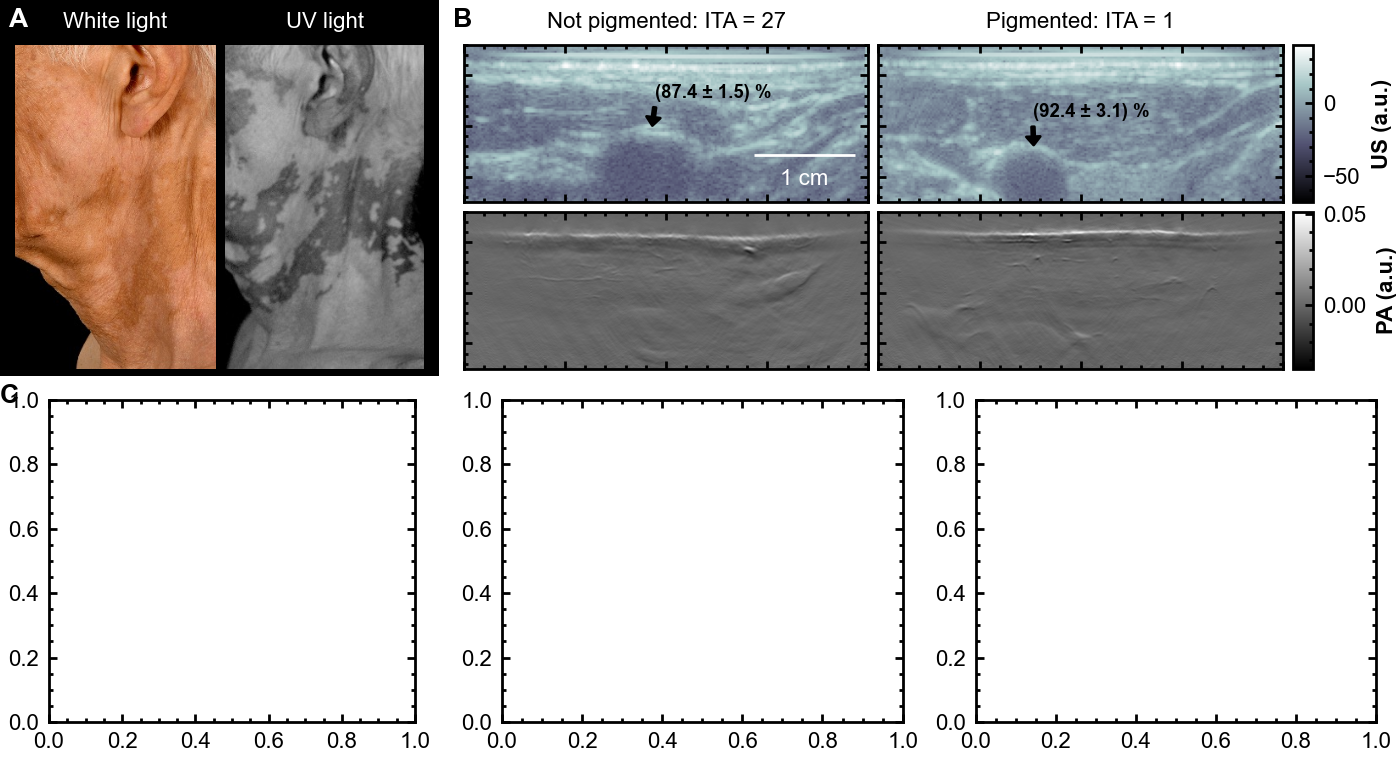

In [9]:
fig = plt.figure(figsize=(7, 4 * 0.95), constrained_layout=True)

subfiga, subfigb = fig.subfigures(2)

subfig_photos, subfig_pa = subfiga.subfigures(1, 2, width_ratios=[0.95, 2.05])
subfig_pa.text(
    0, 1 - 0.02, "B", va="top", ha="left", fontsize="large", fontweight="bold"
)
imgrid = ImageGrid(
    subfig_pa,
    (0.01, 0.02, 0.9, 0.86),
    nrows_ncols=(2, 2),
    axes_pad=0.05,
    share_all=True,
    cbar_mode="edge",
)

for ax in imgrid:
    ax.yaxis.set_tick_params(labelleft=False)
    ax.xaxis.set_tick_params(labelbottom=False)

axus = imgrid[:2]
axpa = imgrid[2:]

scans = ["Data/SKIN36/Scan_21.hdf5", "Data/SKIN36/Scan_18.hdf5"]
ims = []

test = df.set_index(["SkinID", "Region", "Pigment", "Side"])
itas = [
    test.loc[("SKIN36", "Carotid Artery", "Not Pigmented", ""), "ITA"],
    test.loc[("SKIN36", "Carotid Artery", "Pigmented", ""), "ITA"],
]
for ax_us, ax_pa, scan, letter, ita, site in zip(
    axus, axpa, scans, "BC", itas, ["Not pigmented", "Pigmented"]
):
    pat_vitiligo = pat.PAData.from_hdf5(scan)
    pat_vitiligo.set_default_recon(("Model Based", "0"))
    rec = pat_vitiligo.get_scan_reconstructions()
    rec.raw_data = rec.raw_data / pa_weighting[None, None, :, None, None]
    ax_us.set_ylim([-0.0075, 0.008])
    us = pat_vitiligo.get_ultrasound()
    im_us = ax_us.imshow(
        np.squeeze(us.raw_data[0, 0]), extent=us.extent, origin="lower", cmap="bone"
    )
    im_pa = ax_pa.imshow(
        np.squeeze(rec.raw_data[0, 0]), extent=rec.extent, origin="lower", cmap="gray"
    )
    ims.append(im_pa)
    # ax_us.set_title(letter, loc="left")
    ax_us.set_title(f"{site}: ITA = {ita:.0f}", fontweight="normal", fontsize="medium")

    ax_us.yaxis.set_tick_params(labelleft=False)
    ax_us.xaxis.set_tick_params(labelbottom=False)
    ax_pa.yaxis.set_tick_params(labelleft=False)
    ax_pa.xaxis.set_tick_params(labelbottom=False)

so2s_calculated = ["(87.4 ± 1.5) %", "(92.4 ± 3.1) %"]  # from skin36comparisons.ipynb

for j, s in enumerate(scans):
    p = pat.PAData.from_hdf5(s)
    ra = p.get_rois()["artery_", "0"]
    xyra = np.squeeze(np.array(ra.get_polygon().centroid.xy))
    miny = np.argmax(ra.points[:, 1] - np.abs(xyra[0] - ra.points[:, 0]))

    xyarrow = ra.points[miny]
    direction = xyarrow - xyra
    direction /= np.linalg.norm(direction) / 10
    axus[j].annotate(
        so2s_calculated[j],
        xyarrow,
        direction,
        textcoords="offset points",
        fontsize="small",
        fontweight="bold",
        arrowprops={
            "width": 1,
            "headwidth": 5,
            "headlength": 3,
            "facecolor": "k",
            "edgecolor": "k",
        },
    )

asb = AnchoredSizeBar(
    axus[0].transData,
    0.01,
    "1 cm",
    loc="lower right",
    pad=0.1,
    borderpad=0.5,
    sep=5,
    frameon=False,
    color="white",
)
axus[0].add_artist(asb)

clim = [min([i.get_clim()[0] for i in ims]), max([i.get_clim()[1] for i in ims])]
for i in ims:
    i.set_clim(clim)

imgrid.cbar_axes[0].colorbar(im_us, label="US (a.u.)")
imgrid.cbar_axes[1].colorbar(ims[0], label="PA (a.u.)")

# plt.colorbar(ims[0], ax=axpa, label="PA (a.u.)", aspect=10)
# cbar_us = plt.colorbar(im_us, ax=axus, label="US (a.u.)", aspect=10)
# cbar_us.ax.yaxis.set_tick_params(which="minor", right=False)
# cbar_us.ax.yaxis.set_ticks(list(cbar_us.ax.get_ylim()), ["MIN", "MAX"])

subfig_photos.set_facecolor("k")
ax1, ax2 = ImageGrid(
    subfig_photos, (0.02, 0.02, 0.96, 0.86), nrows_ncols=(1, 2), axes_pad=0.05
)


ax1.imshow(forearm_light)
# ax1.set_title("Daylight", fontsize="medium")
subfig_photos.text(
    0.02,
    1 - 0.02,
    "A",
    va="top",
    ha="left",
    fontsize="large",
    fontweight="bold",
    color="white",
)
ax1.axis("off")
ax2.axis("off")

ax1.set_title("White light", color="w", fontweight="normal", fontsize="medium")
ax2.set_title("UV light", color="w", fontweight="normal", fontsize="medium")

# ax1.set_ylim([215, 55])
ax2.imshow(forearm_wood)
ax1.set_xlim([50, forearm_light.size[0] - 10])
ax2.set_xlim([50, forearm_wood.size[0] - 10])
ax1.set_ylim([None, 60])
ax2.set_ylim([None, 60])

# ax2.annotate(
#     "Pigmented",
#     (180, 290),
#     (-10, 20),
#     va="bottom",
#     ha="left",
#     textcoords="offset points",
#     color="white",
#     fontsize="small",
#     arrowprops=dict(arrowstyle="->", connectionstyle="arc3", edgecolor="white"),
# )
# ax2.annotate(
#     "Not\npigmented",
#     (200, 320),
#     (0.65, 0.025),
#     va="bottom",
#     ha="center",
#     textcoords=ax2.transAxes,
#     color="white",
#     fontsize="small",
#     arrowprops=dict(arrowstyle="->", connectionstyle="arc3", edgecolor="white"),
# )

# ax2.annotate("Not pigmented", (430, 140), (-70, -30), textcoords="offset points", color="white", fontsize="small", arrowprops=dict(arrowstyle="->", connectionstyle="arc3", edgecolor="white"))

subfigb1, subfigb2 = subfigb.subfigures(1, 2, width_ratios=[0.95, 2.05])
axes = subfigb2.subplots(1, 2)
axes[0].sharey(axes[1])

ax = subfigb1.subplots()
subfigb1.text(0, 1, "C", va="top", ha="left", fontsize="large", fontweight="bold")
for n, g in df_pig_included.groupby("SkinID"):
    ax.scatter(g["Pigment"], g["ITA"], color=colors[n])
    ax.plot(g["Pigment"], g["ITA"], color=colors[n])
ax.invert_yaxis()
ax.set_ylabel("ITA (degrees)")
ax.set_xlabel("Vitiligo status")
ax.xaxis.set_tick_params(which="minor", top=False, bottom=False)
ax.set_xlim(-0.25, 1.25)

md = smf.mixedlm(
    "ITA ~ Pigment",
    pa_pig_included,
    groups=pa_pig_included["SkinID"],
    re_formula="~Pigment",
)
mdf = md.fit()

p = mdf.pvalues["Pigment[T.Pigmented]"]

ax.text(0, np.min(df_pig_included["ITA"]), p_formatter(p), ha="left", va="top")

ax = axes[0]
for n, g in pa_pig_included.groupby("SkinID"):
    ax.scatter(g["Pigment"], g["PA Melanin"], color=colors[n])
    ax.plot(g["Pigment"], g["PA Melanin"], color=colors[n])

pa_pig_included["y"] = pa_pig_included["PA Melanin"]
md = smf.mixedlm(
    "y ~ Pigment",
    pa_pig_included,
    groups=pa_pig_included["SkinID"],
    re_formula="~Pigment",
)
mdf = md.fit()

p = mdf.pvalues["Pigment[T.Pigmented]"]
ax.text(0, np.max(pa_pig_included["PA Melanin"]), p_formatter(p), ha="left", va="top")

subfigb2.text(0, 1, "D", va="top", ha="left", fontsize="large", fontweight="bold")

ax.set_ylabel("PA melanin (a.u.)")
ax.set_xlabel("Vitiligo status")

ax.xaxis.set_tick_params(which="minor", top=False, bottom=False)
ax.set_xlim(-0.25, 1.25)

ax = axes[1]

for n, g in pa_pig_included.groupby("SkinID"):
    ax.scatter(g["ITA"], g["PA Melanin"], color=colors[n], s=5)
ax.invert_xaxis()

pa_pig_included["y"] = pa_pig_included["PA Melanin"]
md = smf.mixedlm(
    "y ~ ITA", pa_pig_included, groups=pa_pig_included["SkinID"], re_formula="~ITA"
)
mdf = md.fit()
df_clear = pd.DataFrame(
    {"ITA": np.linspace(np.min(pa_pig_included["ITA"]), np.max(pa_pig_included["ITA"]))}
)
df_clear["y"] = mdf.predict(df_clear)

ax.plot(df_clear["ITA"], df_clear["y"], c="k")

ax.set_xlabel("ITA (degrees)")
# ax.set_ylabel("PA melanin (a.u.)")
ax.yaxis.set_tick_params(labelleft=False)
p = mdf.pvalues["ITA"]

ax.text(60, 0.02, p_formatter(p), ha="left", va="top")
ax.legend(
    handles,
    labels,
    frameon=False,
    loc="center left",
    bbox_to_anchor=(1, 0.5),
    title="Study ID",
)

plt.show()

In [ ]:
fig.savefig("figures/figure5.pdf", dpi=300)
fig.savefig("figures/figure5.svg", dpi=300)